# YOLO tutorial: Coding YOLO v3
https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch/

This documents describes the code that I wrote.

In [ ]:
import darknet
import util
from matplotlib import pyplot as plt
%matplotlib inline

import importlib     # During dev only
importlib.reload(darknet)  # During dev only
importlib.reload(util) # During dev only

## Reading in the 'official' config file.

Create a function `darknet.parse_cfg`.

The idea here is to parse the cfg, and store every block as a dict. The attributes of the blocks and their values are stored as key-value pairs in the dictionary. As we parse through the cfg, we keep appending these dicts, denoted by the variable block in our code, to a list blocks. Our function will return this block.

We begin by saving the content of the cfg file in a list of strings. The following code performs some preprocessing on this list.

    file = open(cfgfile, 'r')
    lines = file.read().split('\n')                        # store the lines in a list
    lines = [x for x in lines if len(x) > 0]               # get read of the empty lines 
    lines = [x for x in lines if x[0] != '#']              # get rid of comments
    lines = [x.rstrip().lstrip() for x in lines]           # get rid of fringe whitespaces
    
Now loop over the resultant to get blocks

    block = {}
    blocks = []

    for line in lines:
        if line[0] == "[":               # This marks the start of a new block
            if len(block) != 0:          # If block is not empty, implies it is storing values of previous block.
                blocks.append(block)     # add it the blocks list
                block = {}               # re-init the block
            block["type"] = line[1:-1].rstrip()     
        else:
            key,value = line.split("=") 
            block[key.rstrip()] = value.lstrip()
    blocks.append(block)

    return blocks

In [ ]:
print(darknet.parse_cfg.__doc__)
blocks = darknet.parse_cfg('cfg/yolov3.cfg')
for cc in blocks:
    print(cc)
    print()

## Creating the building blocks
Now we are going to use the list returned by the above parse_cfg to construct PyTorch modules for the blocks present in the config file.

We have 5 types of layers in the list (mentioned above). PyTorch provides pre-built layers for types convolutional and upsample. We will have to write our own modules for the rest of the layers by extending the `nn.Module class`.

Create a function **darknet.create_modules(blocks)**

#### nn.ModuleList
Our function will return a nn.ModuleList. This class is almost like a normal list containing nn.Module objects. However, when we add nn.ModuleList as a member of a nn.Module object (i.e. when we add modules to our network), all the parameters of nn.Module objects (modules) inside the nn.ModuleList are added as parameters of the nn.Module object (i.e. our network, which we are adding the nn.ModuleList as a member of) as well.

#### prev_filter
We need to keep track of number of filters in the layer on which the convolutional layer is being applied. We use the variable `prev_filter` to do this. We initialise this to 3, as the image has 3 filters corresponding to the RGB channels.

#### output_filters
The route layer brings (possibly concatenated) feature maps from previous layers. If there's a convolutional layer right in front of a route layer, then the kernel is applied on the feature maps of previous layers, precisely the ones the route layer brings. Therefore, we need to keep a track of the number of filters in not only the previous layer, but each one of the preceding layers. As we iterate, we append the number of output filters of each block to the list output_filters.

    net_info = blocks[0]     # Captures the information about the input and pre-processing
    module_list = nn.ModuleList()
    prev_filters = 3
    output_filters = []

In [ ]:
print(darknet.create_modules.__doc__)

We iterate over the list of blocks, and create a PyTorch module for each block as we go.

#### nn.Sequential
`nn.Sequential` class is used to sequentially execute a number of nn.Module objects. If you look at the cfg, you will realize a block may contain more than one layer. For example, a block of type convolutional has a batch norm layer as well as leaky ReLU activation layer in addition to a convolutional layer. We string together these layers using the nn.Sequential and the add_module function.

    for index, x in enumerate(blocks[1:]):
        module = nn.Sequential()

        #check the type of block
        #create a new module for the block
        #append to module_list

#### Convolution layers
    if (x["type"] == "convolutional"):
            #Get the info about the layer
            activation = x["activation"]
            try:
                batch_normalize = int(x["batch_normalize"])
                bias = False
            except:
                batch_normalize = 0
                bias = True

            filters= int(x["filters"])
            padding = int(x["pad"])
            kernel_size = int(x["size"])
            stride = int(x["stride"])

            if padding:
                pad = (kernel_size - 1) // 2
            else:
                pad = 0

            #Add the convolutional layer
            conv = nn.Conv2d(prev_filters, filters, kernel_size, stride, pad, bias = bias)
            module.add_module("conv_{0}".format(index), conv)

            #Add the Batch Norm Layer
            if batch_normalize:
                bn = nn.BatchNorm2d(filters)
                module.add_module("batch_norm_{0}".format(index), bn)

            #Check the activation. 
            #It is either Linear or a Leaky ReLU for YOLO
            if activation == "leaky":
                activn = nn.LeakyReLU(0.1, inplace = True)
                module.add_module("leaky_{0}".format(index), activn)

#### Upsampling layers
        #If it's an upsampling layer
        #We use Bilinear2dUpsampling
        elif (x["type"] == "upsample"):
            stride = int(x["stride"])
            upsample = nn.Upsample(scale_factor = 2, mode = "bilinear")
            module.add_module("upsample_{}".format(index), upsample)
            
#### Route layer

The Route Layer, just like any other layer performs an operation (bringing forward previous layer / concatenation). In PyTorch, when we define a new layer, we subclass `nn.Module` and write the operation the layer performs in the forward function of the nn.Module object.

For designing a layer for the Route block, we will have to build a `nn.Module` object that is initialized with values of the attribute layers as it's member(s). Then, we can write the code to concatenate/bring forward the feature maps in the forward function. Finally, we then execute this layer in th `forward` function of our network.

But given the code of concatenation is fairly short and simple (calling torch.cat on feature maps), designing a layer as above will lead to unnecessary abstraction that just increases boiler plate code. Instead, what we can do is put a dummy layer in place of a proposed route layer, and then perform the concatenation directly in the forward function of the nn.Module object representing darknet.

The convolutional layer just in front of a route layer applies it's kernel to (possibly concatenated) feature maps from a previous layers. The following code updates the filters variable to hold the number of filters outputted by a route layer.

    if end < 0:
        #If we are concatenating maps
        filters = output_filters[index + start] + output_filters[index + end]
    else:
        filters= output_filters[index + start]


###### EmptyLayer

    class EmptyLayer(nn.Module):
        def __init__(self):
            super(EmptyLayer, self).__init__()

###### Route Layer code

        #If it is a route layer
        elif (x["type"] == "route"):
            x["layers"] = x["layers"].split(',')
            #Start  of a route
            start = int(x["layers"][0])
            #end, if there exists one.
            try:
                end = int(x["layers"][1])
            except:
                end = 0
            #Positive anotation
            if start > 0: 
                start = start - index
            if end > 0:
                end = end - index
            route = EmptyLayer()
            module.add_module("route_{0}".format(index), route)
            if end < 0:
                filters = output_filters[index + start] + output_filters[index + end]
            else:
                filters= output_filters[index + start]

#### Shortcut layer

        #shortcut corresponds to skip connection
        elif x["type"] == "shortcut":
            shortcut = EmptyLayer()
            module.add_module("shortcut_{}".format(index), shortcut)
            
#### YOLO layer (detection)

        #Yolo is the detection layer
        elif x["type"] == "yolo":
            mask = x["mask"].split(",")
            mask = [int(x) for x in mask]

            anchors = x["anchors"].split(",")
            anchors = [int(a) for a in anchors]
            anchors = [(anchors[i], anchors[i+1]) for i in range(0, len(anchors),2)]
            anchors = [anchors[i] for i in mask]

            detection = DetectionLayer(anchors)
            module.add_module("Detection_{}".format(index), detection)

###### DetectionLayer()
We define a new layer DetectionLayer that holds the anchors used to detect bounding boxes.

    class DetectionLayer(nn.Module):
        def __init__(self, anchors):
            super(DetectionLayer, self).__init__()
            self.anchors = anchors
            
The whole function returns:

    return (net_info, module_list)
    
### Test darknet.create_modules()

In [ ]:
importlib.reload(darknet)  # During dev only
net_info, module_list = darknet.create_modules(blocks)
print("NET_INFO:")
for key in net_info:
    print(key, ":", net_info[key])
print()
print("MODULE LIST")
for mod in module_list:
    print(mod)

## Defining the network
Now we must define our network, using the `create_modules` function above.

    class Darknet(nn.Module):
        def __init__(self, cfgfile):
            super(Darknet, self).__init__()
            self.blocks = parse_cfg(cfgfile)
            self.net_info, self.module_list = create_modules(self.blocks)
            



In [ ]:
importlib.reload(darknet)  # During dev only
dark = darknet.Darknet('cfg/yolov3.cfg')
print(dark.__doc__)
print('Number of blocks:', len(dark.blocks))

## Implementing the forward pass of the network
The forward pass of the network is implemented by overriding the `forward` method of the `nn.Module` class.

`forward` serves two purposes. First, to calculate the output, and second, to transform the output detection feature maps in a way that it can be processed easier (such as transforming them such that detection maps across multiple scales can be concatenated, which otherwise isn't possible as they are of different dimensions).

    def forward(self, x, CUDA):
        modules = self.blocks[1:]
        outputs = {}   #We cache the outputs for the route layer
        
`forward` takes three arguments, self, the input x and CUDA, which if true, would use GPU to accelerate the forward pass.

Here, we iterate over `self.blocks[1:]` instead of self.blocks since the first element of `self.blocks` is a net block which isn't a part of the forward pass.

Since route and shortcut layers need output maps from previous layers, we cache the output feature maps of every layer in a dict outputs. The keys are the the indices of the layers, and the values are the feature maps.

We now iterate over `module_list` which contains the modules of the network. The thing to notice here is that the modules have been appended in the same order as they are present in the configuration file. This means, we can simply run our input through each module to get our output.

    write = 0     #This is explained a bit later
    for i, module in enumerate(modules):        
        module_type = (module["type"])
        
Now we deal with each module by type

#### Convolutional and upsample

        if module_type == "convolutional" or module_type == "upsample":
            x = self.module_list[i](x)
            
#### Route Layer / Shortcut Layer

If you look the code for route layer, we have to account for two cases (as described in part 2). For the case in which we have to concatenate two feature maps we use the torch.cat function with the second argument as 1. This is because we want to concatenate the feature maps along the depth. (In PyTorch, input and output of a convolutional layer has the format batch x channels x H x W. The depth corresponding the the channel dimension).

        elif module_type == "route":
            layers = module["layers"]
            layers = [int(a) for a in layers]

            if (layers[0]) > 0:
                layers[0] = layers[0] - i

            if len(layers) == 1:
                x = outputs[i + (layers[0])]

            else:
                if (layers[1]) > 0:
                    layers[1] = layers[1] - i

                map1 = outputs[i + layers[0]]
                map2 = outputs[i + layers[1]]

                x = torch.cat((map1, map2), 1)

        elif  module_type == "shortcut":
            from_ = int(module["from"])
            x = outputs[i-1] + outputs[i+from_]

#### YOLO (detection) layer

The output of YOLO is a convolutional feature map that contains the bounding box attributes along the depth of the feature map. The attributes bounding boxes predicted by a cell are stacked one by one along each other. So, if you have to access the second bounding of cell at (5,6), then you will have to index it by `map[5,6, (5+C): 2*(5+C)]`. This form is very inconvenient for output processing such as thresholding by a object confidence, adding grid offsets to centers, applying anchors etc.

Another problem is that since detections happen at three scales, the dimensions of the prediction maps will be different. Although the dimensions of the three feature maps are different, the output processing operations to be done on them are similar. It would be nice to have to do these operations on a single tensor, rather than three separate tensors.

To remedy these problems, we introduce the function `predict_transform`

### predict_transform

The function `predict_transform` lives in the file util.py and we will import the function when we use it in forward of Darknet class.

predict_transform takes in 5 parameters; prediction (our output), inp_dim (input image dimension), anchors, num_classes, and an optional CUDA flag

    def predict_transform(prediction, inp_dim, anchors, num_classes, CUDA = True):

In [ ]:
importlib.reload(util)
print(util.predict_transform.__doc__)

`predict_transform` function takes an detection feature map and turns it into a 2-D tensor, where each row of the tensor corresponds to attributes of a bounding box, in the following order:

- 1st bounding box at (0,0)
- 2nd box at (0,0)
- 3rd box at (0,0)
- 1st box at (0,1)

Code:

    batch_size = prediction.size(0)
    stride =  inp_dim // prediction.size(2)
    grid_size = inp_dim // stride
    bbox_attrs = 5 + num_classes
    num_anchors = len(anchors)
    
    prediction = prediction.view(batch_size, bbox_attrs*num_anchors, grid_size*grid_size)
    prediction = prediction.transpose(1,2).contiguous()
    prediction = prediction.view(batch_size, grid_size*grid_size*num_anchors, bbox_attrs)
    
The dimensions of the anchors are in accordance to the height and width attributes of the net block. These attributes describe the dimensions of the input image, which is larger (by a factor of stride) than the detection map. Therefore, we must divide the anchors by the stride of the detection feature map.

    anchors = [(a[0]/stride, a[1]/stride) for a in anchors]
    
#### Transform the output

Sigmoid the x,y coordinates and the objectness score.

    #Sigmoid the  centre_X, centre_Y. and object confidencce
    prediction[:,:,0] = torch.sigmoid(prediction[:,:,0])
    prediction[:,:,1] = torch.sigmoid(prediction[:,:,1])
    prediction[:,:,4] = torch.sigmoid(prediction[:,:,4])

Add the grid offsets to the center cordinates prediction.

    #Add the center offsets
    grid = np.arange(grid_size)
    a,b = np.meshgrid(grid, grid)

    x_offset = torch.FloatTensor(a).view(-1,1)
    y_offset = torch.FloatTensor(b).view(-1,1)

    if CUDA:
        x_offset = x_offset.cuda()
        y_offset = y_offset.cuda()

    x_y_offset = torch.cat((x_offset, y_offset), 1).repeat(1,num_anchors).view(-1,2).unsqueeze(0)

    prediction[:,:,:2] += x_y_offset
    
Apply the anchors to the dimensions of the bounding box.

    #log space transform height and the width
    anchors = torch.FloatTensor(anchors)

    if CUDA:
        anchors = anchors.cuda()

    anchors = anchors.repeat(grid_size*grid_size, 1).unsqueeze(0)
    prediction[:,:,2:4] = torch.exp(prediction[:,:,2:4])*anchors

Apply sigmoid activation to the the class scores

    prediction[:,:,5: 5 + num_classes] = torch.sigmoid((prediction[:,:, 5 : 5 + num_classes]))
    
The last thing we want to do here, is to resize the detections map to the size of the input image. The bounding box attributes here are sized according to the feature map (say, 13 x 13). If the input image was 416 x 416, we multiply the attributes by 32, or the stride variable.

    prediction[:,:,:4] *= stride
    
    return prediction

## Detection layer... again

Now that we have transformed our output tensors, we can now concatenate the detection maps at three different scales into one big tensor. Notice this was not possible prior to our transformation, as one cannot concatenate feature maps having different spatial dimensions.

#### YOLO (detection) layer... again

        elif module_type == 'yolo':        

            anchors = self.module_list[i][0].anchors
            #Get the input dimensions
            inp_dim = int (self.net_info["height"])

            #Get the number of classes
            num_classes = int (module["classes"])

            #Transform 
            x = x.data
            x = predict_transform(x, inp_dim, anchors, num_classes, CUDA)
            if not write:              #if no collector has been intialised. 
                detections = x
                write = 1

            else:       
                detections = torch.cat((detections, x), 1)

        outputs[i] = x


### Test forward pass of network

Two solutions: First using the recommended code (cv2), second trying to do this in numpy / pyplot

In [ ]:
# Official code
import cv2
import numpy as np
import torch
from torch.autograd import Variable
from  matplotlib import pyplot as plt
%matplotlib inline

import darknet
import util

importlib.reload(util)
importlib.reload(darknet)



def get_test_input(input_dim, CUDA):
#     img = cv2.imread(r"/data/detection/images_examples/me_laura_hut.jpg")
    img = cv2.imread(r"/data/detection/images_examples/dog-cycle-car.png")
    img = cv2.resize(img, (input_dim, input_dim))           #Resize to the input dimension
    img_ =  img[:,:,::-1].transpose((2,0,1))  # BGR -> RGB | H X W C -> C X H X W 
    img_ = img_[np.newaxis,:,:,:]/255.0       #Add a channel at 0 (for batch) | Normalise
    img_ = torch.from_numpy(img_).float()     #Convert to float
    img_ = Variable(img_)                     # Convert to Variable
    if CUDA:
        img_ = img_.cuda()
    return img_

# def get_test_input(input_dim, CUDA):
#     img = cv2.imread("pytorch_yolo_v3/dog-cycle-car.png")
#     img = cv2.resize(img, (input_dim, input_dim)) 
#     img_ =  img[:,:,::-1].transpose((2,0,1))
#     img_ = img_[np.newaxis,:,:,:]/255.0
#     img_ = torch.from_numpy(img_).float()
#     img_ = Variable(img_)
    
#     if CUDA:
#         img_ = img_.cuda()
#     num_classes
#     return img_


model = darknet.Darknet("cfg/yolov3.cfg")
# model.cuda()
use_cuda = True
if use_cuda:
    model = model.cuda()
model.eval()
inp = get_test_input(608, use_cuda)
print(inp.size())
print(use_cuda)

# print(next(model.parameters()).is_cuda)
# print(inp.is_cuda)

# pred = model(inp, torch.cuda.is_available())
pred = model(inp, use_cuda)
print(pred)
print(pred.size())




## Downloading pre-trained weights

Weights:

    wget https://pjreddie.com/media/files/yolov3.weights
    
Saved to `~/dev_data/pretrained/yolov3/yolov3.weights`

The official weights file is binary file that contains weights stored in a serial fashion.

Extreme care must be taken to read the weights. The weights are just stored as floats, with nothing to guide us as to which layer do they belong to. If you screw up, there's nothing stopping you to, say, load the weights of a batch norm layer into those of a convolutional layer. Since, you're reading only floats, there's no way to discriminate between which weight belongs to which layer. Hence, we must understand how the weights are stored.

First, the weights belong to only two types of layers, either a batch norm layer or a convolutional layer.

The weights for these layers are stored exactly in the same order as they appear in the configuration file. So, if a convolutional is followed by a shortcut block, and then the shortcut block by another convolutional block, You will expect file to contain the weights of the previous convolutional block, followed by those of the latter.

When the batch norm layer appears in a convolutional block, there are no biases. However, when there's no batch norm layer, bias "weights" have to read from the file.

### Load weights

Let us write a function load weights. It will be a member function of the `darknet.Darknet` class. It'll take one argument other than `self`, the path of the weightsfile.

    def load_weights(self, weightfile):
    
    #Open the weights file
    fp = open(weightfile, "rb")

    #The first 5 values are header information 
    # 1. Major version number
    # 2. Minor Version Number
    # 3. Subversion number 
    # 4,5. Images seen by the network (during training)
    header = np.fromfile(fp, dtype = np.int32, count = 5)
    self.header = torch.from_numpy(header)
    self.seen = self.header[3]
    

In [ ]:
importlib.reload(darknet) # Dev only

print(darknet.Darknet.load_weights.__doc__)

model = darknet.Darknet("cfg/yolov3.cfg")
model.load_weights(r'/data/pretrained/yolov3/yolov3.weights')
print(model.header[:3])
print(model.seen)

The rest of bits now represent the weights, in the order described above. The weights are stored as float32 or 32-bit floats. Let's load rest of the weights in a np.ndarray.

    weights = np.fromfile(fp, dtype = np.float32)
    
Now, we iterate over the weights file, and load the weights into the modules of our network.

    ptr = 0 # keep track of where we are in the weights array
    for i in range(len(self.module_list)):
        module_type = self.blocks[i + 1]["type"]

        #If module_type is convolutional load weights
        #Otherwise ignore.
        
Into the loop, we first check whether the convolutional block has batch_normalise True or not. Based on that, we load the weights.

        if module_type == "convolutional":
            model = self.module_list[i]
            try:
                batch_normalize = int(self.blocks[i+1]["batch_normalize"])
            except:
                batch_normalize = 0

            conv = model[0]

if batch_normalize is True, we load the weights as follows. If batch_norm is not true, simply load the biases of the convolutional layer.



            if (batch_normalize):
                bn = model[1]

                #Get the number of weights of Batch Norm Layer
                num_bn_biases = bn.bias.numel()

                #Load the weights
                bn_biases = torch.from_numpy(weights[ptr:ptr + num_bn_biases])
                ptr += num_bn_biases

                bn_weights = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                ptr  += num_bn_biases

                bn_running_mean = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                ptr  += num_bn_biases

                bn_running_var = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                ptr  += num_bn_biases

                #Cast the loaded weights into dims of model weights. 
                bn_biases = bn_biases.view_as(bn.bias.data)
                bn_weights = bn_weights.view_as(bn.weight.data)
                bn_running_mean = bn_running_mean.view_as(bn.running_mean)
                bn_running_var = bn_running_var.view_as(bn.running_var)

                #Copy the data to model
                bn.bias.data.copy_(bn_biases)
                bn.weight.data.copy_(bn_weights)
                bn.running_mean.copy_(bn_running_mean)
                bn.running_var.copy_(bn_running_var)

            else:
                #Number of biases
                num_biases = conv.bias.numel()

                #Load the weights
                conv_biases = torch.from_numpy(weights[ptr: ptr + num_biases])
                ptr = ptr + num_biases

                #reshape the loaded weights according to the dims of the model weights
                conv_biases = conv_biases.view_as(conv.bias.data)

                #Finally copy the data
                conv.bias.data.copy_(conv_biases)

Now load the conv layer weights

            #Let us load the weights for the Convolutional layers
            num_weights = conv.weight.numel()

            #Do the same as above for weights
            conv_weights = torch.from_numpy(weights[ptr:ptr+num_weights])
            ptr = ptr + num_weights

            conv_weights = conv_weights.view_as(conv.weight.data)
            conv.weight.data.copy_(conv_weights)


**NB: Part four starts here**
https://blog.paperspace.com/how-to-implement-a-yolo-v3-object-detector-from-scratch-in-pytorch-part-4/

We must subject our output to objectness score thresholding and Non-maximal suppression, to obtain what I will call in the rest of this post as the true detections. To do that, we will create a function called `write_results` in the file util.py

    def write_results(prediction, confidence, num_classes, nms_conf = 0.4):
    
The functions takes as as input the prediction, confidence (objectness score threshold), num_classes (80, in our case) and nms_conf (the NMS IoU threshold).

## write_results: object confidence supression
### Supress all boxes with confidence < threshold

For each of the bounding box having a objectness score below a threshold, we set the values of it's every attribute (entire row representing the bounding box) to zero.

    conf_mask = (prediction[:,:,4] > confidence).float().unsqueeze(2)
    prediction = prediction*conf_mask

### Non-maximum supression
The bounding box attributes we have now are described by the center coordinates, as well as the height and width of the bounding box. However, it's easier to calculate IoU of two boxes, using coordinates of a pair of diagnal corners of each box. So, we transform the (center x, center y, height, width) attributes of our boxes, to (top-left corner x, top-left corner y, right-bottom corner x, right-bottom corner y).

    box_corner = prediction.new(prediction.shape)
    box_corner[:,:,0] = (prediction[:,:,0] - prediction[:,:,2]/2)
    box_corner[:,:,1] = (prediction[:,:,1] - prediction[:,:,3]/2)
    box_corner[:,:,2] = (prediction[:,:,0] + prediction[:,:,2]/2) 
    box_corner[:,:,3] = (prediction[:,:,1] + prediction[:,:,3]/2)
    prediction[:,:,:4] = box_corner[:,:,:4]
    
The number of true detections in every image may be different. For example, a batch of size 3 where images 1, 2 and 3 have 5, 2, 4 true detections respectively. Therefore, confidence thresholding and NMS has to be done for one image at once. This means, we cannot vectorise the operations involved, and must loop over the first dimension of prediction (containing indexes of images in a batch).

    batch_size = prediction.size(0)

    write = False 
    # flag is used to indicate that we haven't initialized output, a tensor we will use to collect true detections across the entire batch.

    for ind in range(batch_size):
        image_pred = prediction[ind]          #image Tensor
        #confidence threshholding 
        #NMS

Each bounding box row has 85 attributes, out of which 80 are the class scores. At this point, we're only concerned with the class score having the maximum value. So, we remove the 80 class scores from each row, and instead add the index of the class having the maximum values, as well the class score of that class.

*NB: Perhaps in the future I might wish to also know what the second class is, or the second class if confidence less than a threshold*

        max_conf, max_conf_score = torch.max(image_pred[:,5:5+ num_classes], 1)
        max_conf = max_conf.float().unsqueeze(1)
        max_conf_score = max_conf_score.float().unsqueeze(1)
        seq = (image_pred[:,:5], max_conf, max_conf_score)
        image_pred = torch.cat(seq, 1) # This makes a much simpler tensor, with the five positional arguments,
                                        # then the confidence (of the most confident class) and the arg of the most
                                        # confidence class
                                        
Get rid of zeroed out rows

        non_zero_ind = (torch.nonzero(image_pred[:,4]))
        image_pred_ = image_pred[non_zero_ind.squeeze(),:].view(-1,7)
        if image_pred_.shape[0] == 0:
            continue # If no detections, stop considering this image.
        
Get the classes detected in a an image.

        #Get the various classes detected in the image
        img_classes = unique(image_pred_[:,-1]) # -1 index holds the class index
        
#### Aside: Unique function

Since there can be multiple true detections of the same class, we use a function called unique to get classes present in any given image.

    def unique(tensor):
        tensor_np = tensor.cpu().numpy()
        unique_np = np.unique(tensor_np)
        unique_tensor = torch.from_numpy(unique_np)

        tensor_res = tensor.new(unique_tensor.shape)
        tensor_res.copy_(unique_tensor)
        return tensor_res

#### Back to NMS

Loop through classes

        for cls in img_classes:
            #perform NMS
            #get the detections with one particular class
            cls_mask = image_pred_*(image_pred_[:,-1] == cls).float().unsqueeze(1)
            class_mask_ind = torch.nonzero(cls_mask[:,-2]).squeeze()
            image_pred_class = image_pred_[class_mask_ind].view(-1,7)

            #sort the detections such that the entry with the maximum objectness
            #confidence is at the top
            conf_sort_index = torch.sort(image_pred_class[:,4], descending = True )[1]
            image_pred_class = image_pred_class[conf_sort_index]
            idx = image_pred_class.size(0)   #Number of detections
            
Now do non-maximum supression

            for i in range(idx):
                #Get the IOUs of all boxes that come after the one we are looking at 
                #in the loop
                try:
                    ious = bbox_iou(image_pred_class[i].unsqueeze(0), image_pred_class[i+1:])
                except ValueError:
                    break

                except IndexError:
                    break

                #Zero out all the detections that have IoU > treshhold
                iou_mask = (ious < nms_conf).float().unsqueeze(1)
                image_pred_class[i+1:] *= iou_mask       

                #Remove the non-zero entries
                non_zero_ind = torch.nonzero(image_pred_class[:,4]).squeeze()
                image_pred_class = image_pred_class[non_zero_ind].view(-1,7)
                
#### Writing the predictions

The function write_results outputs a tensor of shape D x 8. Here D is the true detections in all of images, each represented by a row. Each detections has 8 attributes, namely, index of the image in the batch to which the detection belongs to, 4 corner coordinates, objectness score, the score of class with maximum confidence, and the index of that class.

Just as before, we do not initialize our output tensor unless we have a detection to assign to it. Once it has been initialized, we concatenate subsequent detections to it. We use the write flag to indicate whether the tensor has been initialized or not. At the end of loop that iterates over classes, we add the resultant detections to the tensor output.

            batch_ind = image_pred_class.new(image_pred_class.size(0), 1).fill_(ind)      
            #Repeat the batch_id for as many detections of the class cls in the image
            seq = batch_ind, image_pred_class

            if not write:
                output = torch.cat(seq,1)
                write = True
            else:
                out = torch.cat(seq,1)
                output = torch.cat((output,out))


**NB: Start of part five**
https://blog.paperspace.com/how-to-implement-a-yolo-v3-object-detector-from-scratch-in-pytorch-part-5/



In [ ]:
importlib.reload(darknet) # Dev only
importlib.reload(util)

model = darknet.Darknet("cfg/yolov3.cfg")
model.load_weights(r'/data/pretrained/yolov3/yolov3.weights')

inp = get_test_input(608, use_cuda)

use_cuda = True
if use_cuda:
    model = model.cuda()
model.eval()
inp = get_test_input(608, use_cuda)

pred = model(inp, use_cuda)

output = util.write_results(pred, 0.5, 80, nms_conf=0.4)

In [ ]:
print(output.shape)
print(output.cpu().numpy())

## Building the input and output pipelines.
Tutorial uses `detect_tutorial.py`. My reduced version uses `detector.py`.

`detector` is the module that future programmes will call.

`detect_tutorial` uses argpass, but I'll replace this with a funtion, as I don't like argpass.

### Read class names

In [ ]:
import detector
import torchvision
importlib.reload(detector) # Dev only

yolo = detector.YOLO()
# print(yolo.class_names)


### Create image dataset (for detector.YOLO.infer_write_dir method)

In [68]:
import detector
import importlib     # During dev only
importlib.reload(detector) # Dev only

yolo = detector.YOLO()
yolo.infer_write_dir(r'/data/detection/images_examples')



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


This pred contains 2 objects
Classes in this image: ['person']
** IMAGE END **
No detections for image sea.jpg
***BATCH END***
This pred contains 2 objects
Classes in this image: ['dog', 'person']
** IMAGE END **
This pred contains 6 objects
Classes in this image: ['fire hydrant', 'car', 'person']
** IMAGE END **
***BATCH END***
This pred contains 8 objects
Classes in this image: ['bottle', 'person']
** IMAGE END **
This pred contains 1 objects
Classes in this image: ['person']
** IMAGE END **
***BATCH END***
This pred contains 5 objects
Classes in this image: ['bowl', 'diningtable', 'chair', 'person']
** IMAGE END **
This pred contains 31 objects
Classes in this image: ['person']
** IMAGE END **
***BATCH END***
This pred contains 4 objects
Classes in this image: ['aeroplane']
** IMAGE END **
No detections for image tree.png
***BATCH END***
This pred contains 8 objects
Classes in this image: ['handbag', 'tie', 'person']
** IMAGE END **
This pred contains 10 objects
Classes in this imag

**DEBUG CODE BELOW**

In [59]:
from torch.utils.data import Dataset, DataLoader
import util, detector
import numpy as np
import importlib
importlib.reload(detector) # Dev only
importlib.reload(util) # Dev only

img_dataset = detector.ImagesDataset(r'/data/detection/images_examples')
loader = DataLoader(img_dataset, batch_size=2, shuffle=True, collate_fn=detector.collate_fn)

batch = next(iter(loader))
print(batch['img_filename'])

input_imgs = batch['trans_image']
input_imgs = input_imgs.cuda()

yolo = detector.YOLO()

prediction = yolo.model(input_imgs, True)
preds = util.write_results(prediction, 0.5,
                               80,
                               nms_conf=0.4)


['port_city.jpg', 'washington_stations.jpg']


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [60]:
print("Batch contains", preds.size(0), "objects")
print(preds.size())
indx = 0
print(batch['original_image_size'][indx])
print(batch['padding'][indx])
# Find preds with indx = 0 
this_pred = preds[preds[:, 0] == indx].cpu()
this_pred = this_pred.numpy()
print("This image contains", this_pred.shape[0], "objects")


Batch contains 19 objects
torch.Size([19, 8])
(960, 720)
(0, 120, 0, 120)
This image contains 5 objects


In [61]:
classes = this_pred[:, 7]
classes = classes.astype(np.int8)
print(classes)
classes_str = [yolo.class_names[class_] for class_ in classes]
print(classes_str)
print(list(set(classes_str)))

[0 0 2 2 7]
['person', 'person', 'car', 'car', 'truck']
['car', 'truck', 'person']


#### Convert coordinates of this_pred

In [67]:
def resize_coords(coord, trans_size, orig_size):
    factor = float(orig_size) / float(trans_size)
    return np.round(coord * factor).astype(np.int16)

def translate_coords(x1, x2, y1, y2, padding):
    left, top, right, bottom = padding
    x1 -= left
    x2 -= left
    y1 -= top
    y2 -= top
    return x1, x2, y1, y2

def _crop_to_original_size(x1, x2, y1, y2, orig_size):
    x1[x1<0] = 0
    x2[x2>orig_size[0]] = orig_size[0]
    y1[y1<0] = 0
    y2[y2>orig_size[1]] = orig_size[1]
    return x1, x2, y1, y2
    
original_size = batch['original_image_size'][indx]
max_orig_size = np.max(original_size)
img = batch['original_image'][indx]
padding = batch['padding'][indx]

# print(this_pred)
x1 = this_pred[:, 1]
y1 = this_pred[:, 2]
x2 = this_pred[:, 3]
y2 = this_pred[:, 4]

x1 = resize_coords(x1, 608, max_orig_size)
x2 = resize_coords(x2, 608, max_orig_size)
y1 = resize_coords(y1, 608, max_orig_size)
y2 = resize_coords(y2, 608, max_orig_size)

x1, x2, y1, y2 = translate_coords(x1, x2, y1, y2, padding)


# print(this_pred)
# this_pred[:, 1] = x1
# this_pred[:, 2] = y1
# this_pred[:, 3] = x2
# this_pred[:, 4] = y2
# print(this_pred)

print(x1)
print(x2)
x1, x2, y1, y2 = _crop_to_original_size(x1, x2, y1, y2, original_size)
print(x1)
print(x2)

[720  -7 160 221 798]
[907 267 314 298 929]
[720   0 160 221 798]
[907 267 314 298 929]


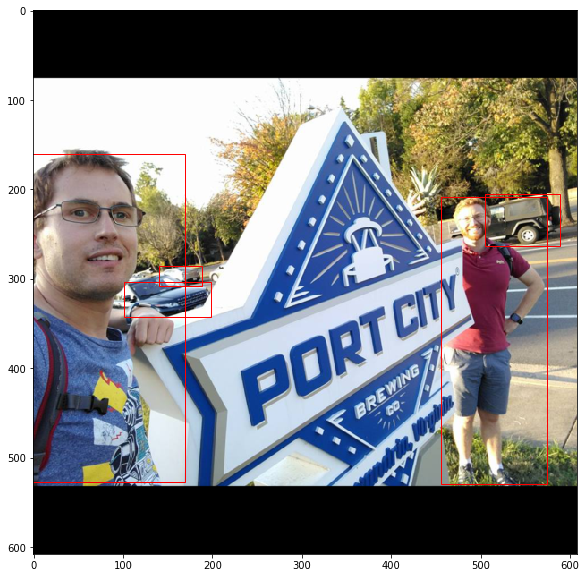

In [38]:
# Plotting -- original image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms, utils
import torch
% matplotlib inline

img = batch['trans_image'][indx, :, :, :]
img = img.numpy()
img = img.transpose(1, 2, 0)
fig,ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img)

for rect_plot in range(this_pred.size(0)):
    width = this_pred[rect_plot, 3] - this_pred[rect_plot, 1]
    height = this_pred[rect_plot, 4] - this_pred[rect_plot, 2]
    rect = patches.Rectangle((this_pred[rect_plot, 1], this_pred[rect_plot, 2]), width, height,linewidth=1,
                             edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

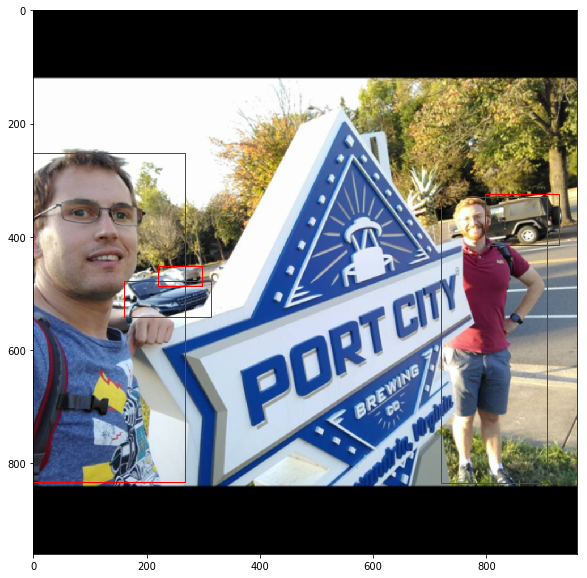

In [65]:
# Resize
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms, utils
import torch
% matplotlib inline

original_size = batch['original_image_size'][indx]
max_orig_size = np.max(original_size)

img = batch['trans_image'][indx, :, :, :]
img = transforms.functional.to_pil_image(img)
img = transforms.functional.resize(img, int(max_orig_size))
img = np.array(img)
fig,ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img)


def resize_coords(coord, trans_size, orig_size):
    factor = float(orig_size) / float(trans_size)
    return int(np.round(coord * factor))

for rect_plot in range(this_pred.size(0)):
    x1 = this_pred[rect_plot, 1]
    x1 = resize_coords(x1, 608, max_orig_size)
    x2 = this_pred[rect_plot, 3]
    x2 = resize_coords(x2, 608, max_orig_size)
    y1 = this_pred[rect_plot, 2]
    y1 = resize_coords(y1, 608, max_orig_size)
    y2 = this_pred[rect_plot, 4]
    y2 = resize_coords(y2, 608, max_orig_size)
    width = x2 - x1
    height = y2 - y1
    rect = patches.Rectangle((x1, y1), width, height,linewidth=1,
                             edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

In [1]:
# Now remove the cropping
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms, utils
import torch
% matplotlib inline

original_size = batch['original_image_size'][indx]
max_orig_size = np.max(original_size)

img = batch['original_image'][indx]
padding = batch['padding'][indx]
# img = transforms.functional.to_pil_image(img)
# img = transforms.functional.resize(img, int(max_orig_size))
img = np.array(img)
fig,ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img)


def resize_coords(coord, trans_size, orig_size):
    factor = float(orig_size) / float(trans_size)
    return int(np.round(coord * factor))

def translate_coords(x1, x2, y1, y2, padding):
    left, top, right, bottom = padding
    x1 -= left
    x2 -= left
    y1 -= top
    y2 -= top
    return x1, x2, y1, y2


for rect_plot in range(this_pred.size(0)):

    
    
    width = x2 - x1
    height = y2 - y1
    rect = patches.Rectangle((x1, y1), width, height,linewidth=1,
                             edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
# fig.savefig(r'/data/tmp/test.jpg')

NameError: name 'batch' is not defined